# Complex CAPTCHA-Solver Demo 
# (Note: using data generated by 'captcha' python library)
---

In [1]:
# Functions from other notebook file.
from ipynb.fs.full.shared_functions import *

import tensorflow
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as pyplot
import os

In [2]:
# Suppress tensorflow log messages.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
# Move one directory back to the project root.
os.chdir("..")

In [3]:
# GLOBALS
DATA_DIRECTORY = os.path.join(os.getcwd() + '/datasets/complex')

IMAGE_HEIGHT = 100
IMAGE_WIDTH = 100
IMAGE_CHANNELS = 3

CATEGORIES = 10 # represents digits 0-9
DIMENSIONS = 4  # 4-digit CAPTCHA images

TRAINING_EPOCHS = 20

TRAINING_BATCH_SIZE = 64
VALIDATION_BATCH_SIZE = 64
TESTING_BATCH_SIZE = 128

---
## Prepare the Dataset



Store each CAPTCHA-image file path with its respective label
into a pandas DataFrame.

In [4]:
data_frame = create_captcha_dataframe(DATA_DIRECTORY)
data_frame.head()

,label,file
0,5458,/home/t-visor/repositories/captcha-tensorflow/...
1,4773,/home/t-visor/repositories/captcha-tensorflow/...
2,1562,/home/t-visor/repositories/captcha-tensorflow/...
3,8946,/home/t-visor/repositories/captcha-tensorflow/...
4,4378,/home/t-visor/repositories/captcha-tensorflow/...


---
Shuffle the data and create a training set, validation set, and testing set.

In [5]:
train_indices, validation_indices, test_indices = shuffle_and_split_data(data_frame)

print('train count: %s, validation count: %s, test count: %s' % (
    len(train_indices), len(validation_indices), len(test_indices)))

train count: 4900, validation count: 2100, test count: 3000


---
## Neural Network Structure

**'relu'** stands for **'Rectified Linear Unit'**, the most commonly used activation function for convolutional neural networks.

**'softmax'** is another activation function used for classifying data.

Activation functions are analagous to the 'firing' of neurons in biological neural networks.

**Layers**:
- Convolutional layer: applies a filter to the CAPTCHA image to extract features (characters and/or digits) from the image
- Pooling layer: immediately follows a convolutional layer and used to downscale the image after each filter is applied
- Flattening layer: converts the CAPTCHA image represented as a 3D tensor (array) to a 1D tensor
- Dense layer: used to assist with operations on an n-dimensional tensor such as rotation, scaling, etc
- Reshape layer: used to restructure the output of the neural network

In [6]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

input_layer = tensorflow.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

hidden_layers = layers.Conv2D(32, 3, activation='relu')(input_layer)
hidden_layers = layers.MaxPooling2D((2, 2))(hidden_layers)
hidden_layers = layers.Conv2D(64, 3, activation='relu')(hidden_layers)
hidden_layers = layers.MaxPooling2D((2, 2))(hidden_layers)
hidden_layers = layers.Conv2D(64, 3, activation='relu')(hidden_layers)
hidden_layers = layers.MaxPooling2D((2, 2))(hidden_layers)

hidden_layers = layers.Flatten()(hidden_layers)

hidden_layers = layers.Dense(1024, activation='relu')(hidden_layers)
hidden_layers = layers.Dense(DIMENSIONS * CATEGORIES, activation='softmax')(hidden_layers)
hidden_layers = layers.Reshape((DIMENSIONS, CATEGORIES))(hidden_layers)

model = models.Model(inputs=input_layer, outputs=hidden_layers)

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics= ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0     

---
## Train the Model

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint


training_set_generator = get_captcha_generator(data_frame, train_indices, \
                                               for_training=True, batch_size=TRAINING_BATCH_SIZE)
validation_set_generator = get_captcha_generator(data_frame, validation_indices, \
                                                 for_training=True, batch_size=VALIDATION_BATCH_SIZE)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit(training_set_generator,
                    steps_per_epoch=len(train_indices)//TRAINING_BATCH_SIZE,
                    epochs=TRAINING_EPOCHS,
                    validation_data=validation_set_generator,
                    validation_steps=len(validation_indices)//VALIDATION_BATCH_SIZE)

Epoch 1/20
76/76 [==============================] - 11s 89ms/step - loss: 2.3079 - accuracy: 0.0969 - val_loss: 2.3028 - val_accuracy: 0.1050
Epoch 2/20
76/76 [==============================] - 5s 73ms/step - loss: 2.3027 - accuracy: 0.0984 - val_loss: 2.3030 - val_accuracy: 0.0958
Epoch 3/20
76/76 [==============================] - 5s 72ms/step - loss: 2.3026 - accuracy: 0.1024 - val_loss: 2.3030 - val_accuracy: 0.0959
Epoch 4/20
76/76 [==============================] - 6s 75ms/step - loss: 2.3026 - accuracy: 0.1015 - val_loss: 2.3031 - val_accuracy: 0.0957
Epoch 5/20
76/76 [==============================] - 5s 71ms/step - loss: 2.3025 - accuracy: 0.1036 - val_loss: 2.3032 - val_accuracy: 0.0950
Epoch 6/20
76/76 [==============================] - 5s 71ms/step - loss: 2.3025 - accuracy: 0.1045 - val_loss: 2.3033 - val_accuracy: 0.0945
Epoch 7/20
76/76 [==============================] - 5s 72ms/step - loss: 2.3025 - accuracy: 0.1048 - val_loss: 2.3034 - val_accuracy: 0.0941
Epoch 8/20
7

---
## Analyze Model Performance

Plot the accuracy and loss metrics

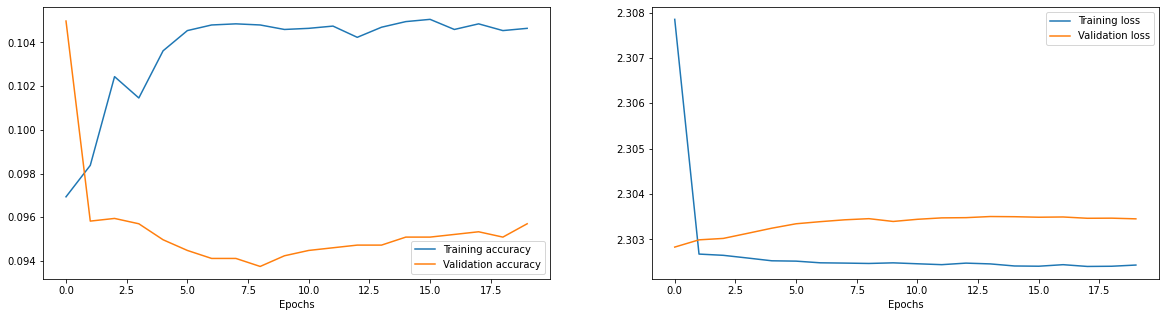

In [8]:
figure, axes = pyplot.subplots(1, 2, figsize=(20, 5))

axes[0].plot(history.history['accuracy'], label='Training accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation accuracy')
axes[0].set_xlabel('Epochs')
axes[0].legend() 

axes[1].plot(history.history['loss'], label='Training loss')
axes[1].plot(history.history['val_loss'], label='Validation loss')
axes[1].set_xlabel('Epochs')
axes[1].legend()

Use some 'unseen' test samples

In [9]:
testing_set_generator = get_captcha_generator(data_frame, test_indices, 
                                              for_training=False, batch_size=TESTING_BATCH_SIZE)
dict(zip(model.metrics_names, model.evaluate(testing_set_generator, steps=len(test_indices)//TESTING_BATCH_SIZE)))

23/23 [==============================] - 3s 112ms/step - loss: 2.3036 - accuracy: 0.0962


{'loss': 2.303628921508789, 'accuracy': 0.09621263295412064}

---
## Visualize Model Performance
### (Note that the model gives the same prediction value... this means it's not being trained properly and likely due to having too small of a dataset)

In [10]:
testing_set_generator = get_captcha_generator(data_frame, test_indices, 
                                              for_training=False, batch_size=TESTING_BATCH_SIZE)

captcha_images, captcha_text = next(testing_set_generator)

predictions = model.predict_on_batch(captcha_images)

true_values = tensorflow.math.argmax(captcha_text, axis=-1)
predictions = tensorflow.math.argmax(predictions, axis=-1)

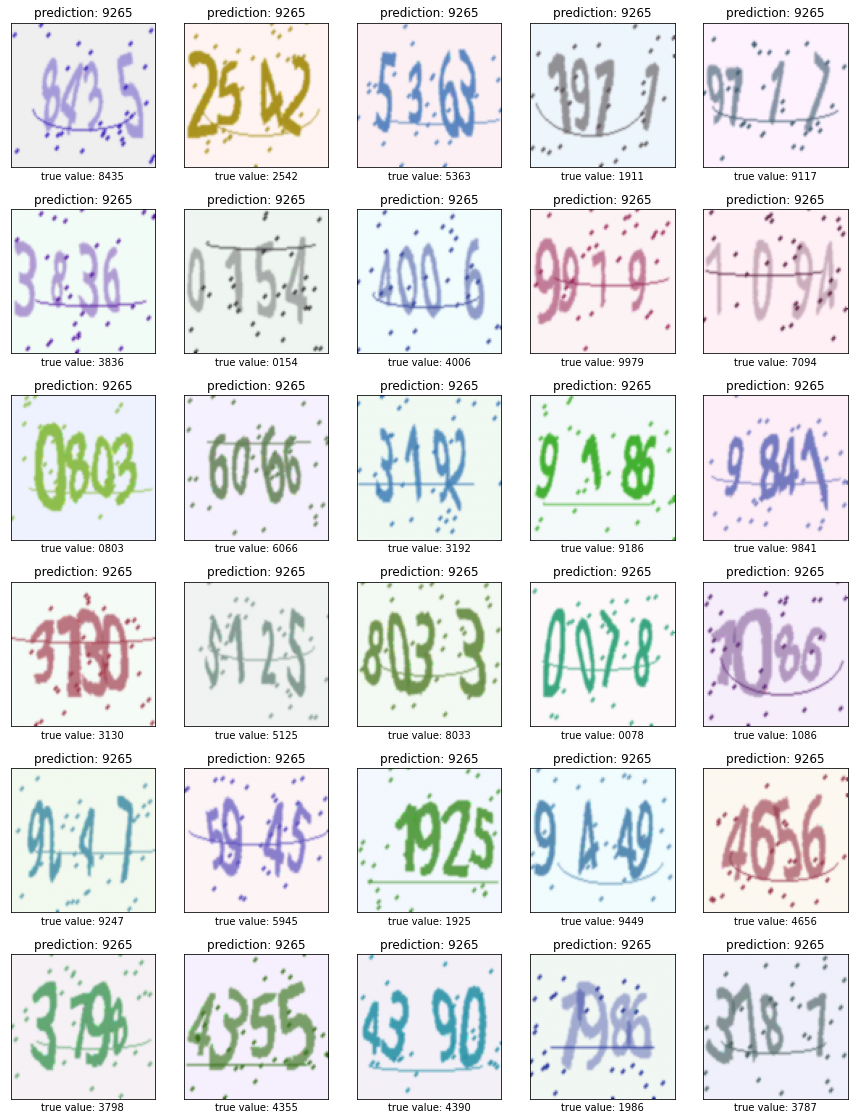

In [11]:
display_predictions_from_model(captcha_images, predictions, true_values)

## Save the Model

In [12]:
#model.save('my_model')